<a href="https://colab.research.google.com/github/AkashKoley012/Deep-Learning-Projects/blob/main/Netflix%20Stock%20Price%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collecting Data

In [180]:
!kaggle datasets download -d jainilcoder/netflix-stock-price-prediction

Dataset URL: https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction
License(s): CC0-1.0
netflix-stock-price-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [181]:
import zipfile
zip_ref = zipfile.ZipFile('/content/netflix-stock-price-prediction.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Imports modules

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Feature Engineering

In [183]:
df = pd.read_csv('/content/NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [184]:
df.shape

(1009, 7)

# Scaled Data

In [185]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df[['Close']].values)
data

array([[0.04451626],
       [0.06954849],
       [0.06701469],
       ...,
       [0.4272515 ],
       [0.37509011],
       [0.38507243]])

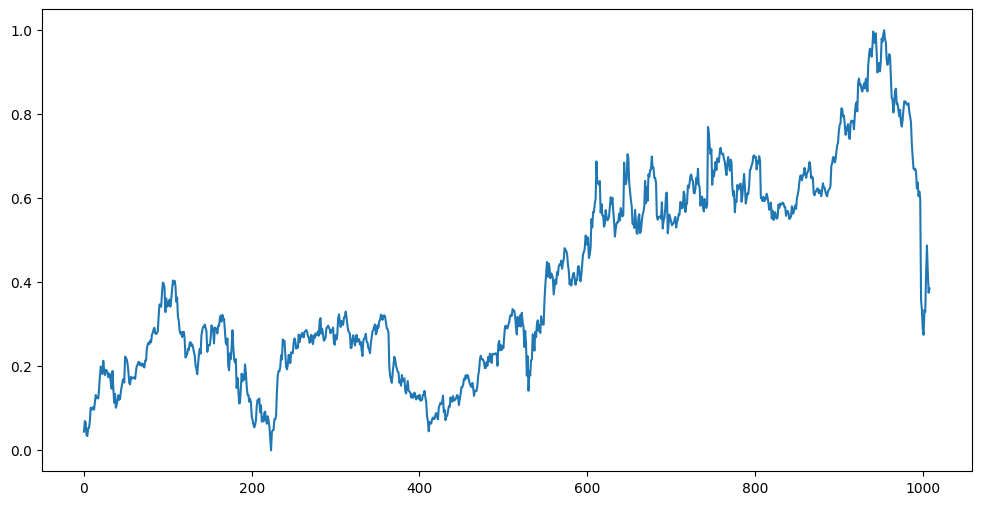

In [186]:
plt.figure(figsize=(12,6))
plt.plot(data)
plt.show()

In [187]:
df['Close'].values

array([254.259995, 265.720001, 264.559998, ..., 429.480011, 405.600006,
       410.170013])

# Train Test

In [188]:
def prepare_data(data, seq_len=50):
  X = []
  y = []

  for i in range(len(data)-seq_len):
    X.append(data[i:(i+seq_len)])
    y.append(data[i+seq_len])

  return np.array(X), np.array(y)

In [189]:
X, y = prepare_data(data, seq_len=50)

In [190]:
# for i in range(len(data)-50):
#   X = []
#   X.append(data[i:(i+50)])
#   print(np.array(X))
#   break

In [191]:
X.shape, y.shape

((959, 50, 1), (959, 1))

In [192]:
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [193]:
X_train.shape, y_train.shape

((767, 50, 1), (767, 1))

In [194]:
torch.tensor(X_train, dtype=torch.long)[0].squeeze(-1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

# Dataset & DataLoader

In [260]:
class StockDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [261]:
train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)

In [262]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [263]:
for X, y in train_dataloader:
  print(X.shape)
  break

torch.Size([64, 50, 1])


In [264]:
for X, y in train_dataloader:
  print(X)
  break

tensor([[[0.4108],
         [0.3942],
         [0.4057],
         ...,
         [0.5450],
         [0.5091],
         [0.5277]],

        [[0.5405],
         [0.5435],
         [0.5427],
         ...,
         [0.6368],
         [0.5574],
         [0.5490]],

        [[0.2244],
         [0.2611],
         [0.2662],
         ...,
         [0.1792],
         [0.1639],
         [0.1681]],

        ...,

        [[0.2753],
         [0.2794],
         [0.2882],
         ...,
         [0.2484],
         [0.2522],
         [0.2446]],

        [[0.1321],
         [0.1182],
         [0.1188],
         ...,
         [0.1075],
         [0.1218],
         [0.1336]],

        [[0.3737],
         [0.3995],
         [0.3966],
         ...,
         [0.2729],
         [0.2855],
         [0.2940]]])


# Neural Network

In [297]:
class LSTM(nn.Module):
  def __init__(self):
    super().__init__()
    # input structure for lstm
    # (batch_size, seq_len or timesteps, input_dim or #features)
    # self.embedding = nn.Embedding(1+1, 128,) # (input_dim + 1, any)
    self.lstm = nn.LSTM(1, 128, batch_first=True) # (seq_len, any)
    self.fc = nn.Linear(128, 1) #(any, output_dim)
  def forward(self, x):
    # x = self.embedding(X)
    x, y = self.lstm(x) # (intermidiate_hidden_state, (last_hidden_state, last_cell_state))
    # print(x.shape)
    x = self.fc(x[:,-1,:]) # (batch_size, timesteps, features)
    # we need all batchs last timestep all features
    return x

In [201]:
int(X_train.max().item())

0

# Train & Evaluation

In [202]:
lr = 0.01
epochs = 100

In [298]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [287]:
X.shape

torch.Size([64, 50, 1])

In [299]:
for X, y in train_dataloader:
  # print(X.shape, y.shape)
  y_pred = model(X)
  print(y_pred.shape, y.shape)
  break

torch.Size([64, 1]) torch.Size([64, 1])


In [300]:
for epoch in range(epochs):
  total_loss = 0
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f'Epoch: {epoch+1}, Loss: {total_loss/len(train_dataloader)}')


Epoch: 0, Loss: 0.11985225820293029
Epoch: 1, Loss: 0.026119235437363386
Epoch: 2, Loss: 0.014675055824530622
Epoch: 3, Loss: 0.004239969188347459
Epoch: 4, Loss: 0.0015769672851699095
Epoch: 5, Loss: 0.001279303008535256
Epoch: 6, Loss: 0.0011285618481148656
Epoch: 7, Loss: 0.0009990912415863324
Epoch: 8, Loss: 0.0009744582348503172
Epoch: 9, Loss: 0.0009520260452215249
Epoch: 10, Loss: 0.0009213494292149941
Epoch: 11, Loss: 0.000920631039965277
Epoch: 12, Loss: 0.0009186177000325794
Epoch: 13, Loss: 0.0009525539110957956
Epoch: 14, Loss: 0.0009426902203510205
Epoch: 15, Loss: 0.0009502752460927392
Epoch: 16, Loss: 0.0008695921278558671
Epoch: 17, Loss: 0.0008729758264962584
Epoch: 18, Loss: 0.0009152915930220237
Epoch: 19, Loss: 0.0009992611812776886
Epoch: 20, Loss: 0.0007997861782011265
Epoch: 21, Loss: 0.0008088598939745376
Epoch: 22, Loss: 0.0007726004744957512
Epoch: 23, Loss: 0.0007904247710636506
Epoch: 24, Loss: 0.0007489324707421474
Epoch: 25, Loss: 0.0007647957293859994
Epo

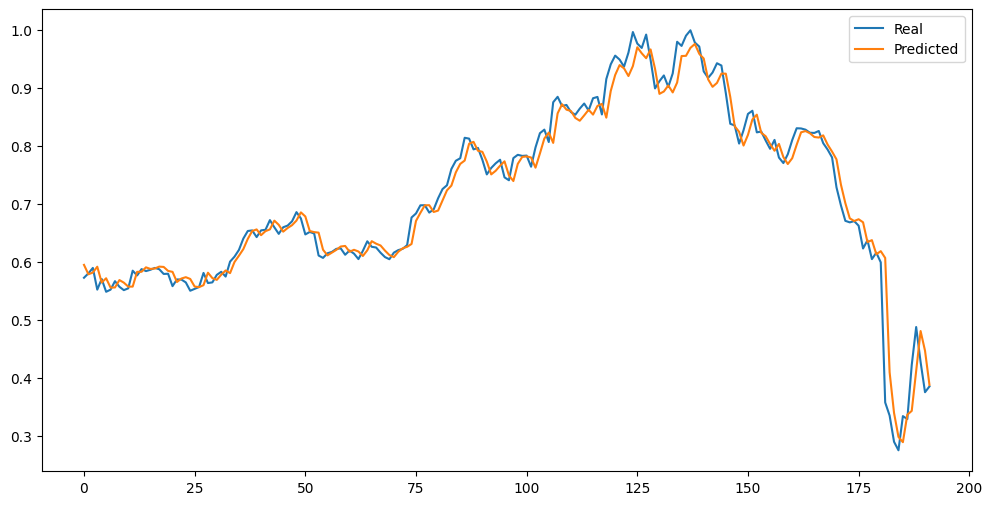

In [306]:
model.eval()

y_pred = []
y_real = []

with torch.no_grad():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_pred.extend(model(X).squeeze(-1).cpu().numpy())
    y_real.extend(y.squeeze(-1).cpu().numpy())

# y_pred = scaler.inverse_transform(y_pred)  # Rescale to original price
plt.figure(figsize=(12,6))
plt.plot(y_real, label='Real')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()